In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')
from datetime import date

RANDOM_SEED = np.random.seed(0)

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y')

In [3]:
data = pd.read_csv('c_df.csv', parse_dates=[2], date_parser=parser)

In [4]:
wheat=data[data['item']=='wheat']

In [5]:
wheat = wheat.reset_index()

In [6]:
wheat

,index,terms,item,year,value
0,1,current,wheat,2020-01-01,2703.680083
1,74,current,wheat,2019-01-01,1543.214950
2,147,current,wheat,2018-01-01,2433.366764
3,220,current,wheat,2017-01-01,2109.701978
4,293,current,wheat,2016-01-01,2066.813848
...,...,...,...,...,...
44,3213,current,wheat,1976-01-01,436.100000
45,3286,current,wheat,1975-01-01,359.660000
46,3359,current,wheat,1974-01-01,282.300000
47,3432,current,wheat,1973-01-01,333.750000


In [7]:
wheat.dtypes

index             int64
terms            object
item             object
year     datetime64[ns]
value           float64
dtype: object

In [8]:
wheat=wheat.drop(['index', 'terms','item'], axis=1)
wheat.set_index('year')

,value
year,
2020-01-01,2703.680083
2019-01-01,1543.214950
2018-01-01,2433.366764
2017-01-01,2109.701978
2016-01-01,2066.813848
...,...
1976-01-01,436.100000
1975-01-01,359.660000
1974-01-01,282.300000


In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(wheat, test_size=0.2, random_state=25)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")

# No. of training examples: 39
# No. of testing examples: 10

No. of training examples: 39
No. of testing examples: 10


In [10]:
train=wheat.iloc[:40,:]

In [11]:
test=wheat.iloc[40:,:]

<AxesSubplot:xlabel='year'>

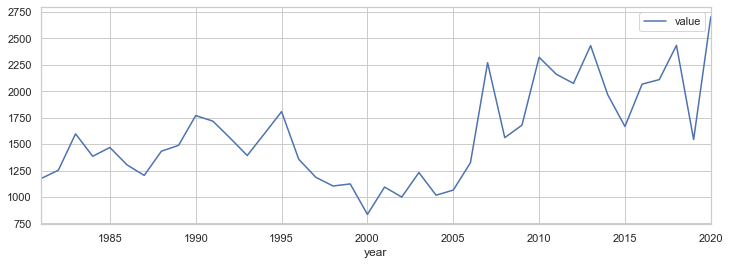

In [12]:
train.plot(figsize=(12,4),x='year',y='value')

In [13]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset,autolag = "AIC")
    print("1. Augmented Dickey-Fuller Statistic : ",dftest[0])
    print("2. P-Value : ",dftest[1])
    print("3. Num of Lags : ",dftest[2])
    print("4. Num of Obs used for Regression and Critial Values Calculations : ",dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t",key, " : ",val)
    if dftest[0] < dftest[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")
    

In [14]:
ad_test(train['value'])

1. Augmented Dickey-Fuller Statistic :  -4.119332125713218
2. P-Value :  0.0008996651078193121
3. Num of Lags :  10
4. Num of Obs used for Regression and Critial Values Calculations :  29
5. Critical Values : 
	 1%  :  -3.6790595944893187
	 5%  :  -2.9678817237279103
	 10%  :  -2.6231583472057074
Reject Ho - Time Series is Stationary


#### Here in the results, we can see that the p-value for time series is greater than 0.05, and we can say we fail to reject the null hypothesis and the time series is non-stationary. 

In [15]:
fdif = train['value'].diff(periods=1)
fdif= fdif[~np.isnan(fdif)]
ad_test(fdif)


1. Augmented Dickey-Fuller Statistic :  -2.667317173379865
2. P-Value :  0.07986657401011599
3. Num of Lags :  9
4. Num of Obs used for Regression and Critial Values Calculations :  29
5. Critical Values : 
	 1%  :  -3.6790595944893187
	 5%  :  -2.9678817237279103
	 10%  :  -2.6231583472057074
Failed to Reject Ho - Time Series is Non-Stationary


In [16]:
sdif = train['value'].diff().diff()
sdif =sdif[~np.isnan(sdif)]
ad_test(sdif)

1. Augmented Dickey-Fuller Statistic :  -4.652978570936055
2. P-Value :  0.00010304141574243705
3. Num of Lags :  4
4. Num of Obs used for Regression and Critial Values Calculations :  33
5. Critical Values : 
	 1%  :  -3.6461350877925254
	 5%  :  -2.954126991123355
	 10%  :  -2.6159676124885216
Reject Ho - Time Series is Stationary


#### Here in the results, we can see that the p-value for time series is less than 0.05, so we can say we rejected the null hypothesis and the time series is now stationary. 

In [17]:
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
# seed random number generator
seed(1)
# create white noise series
series = [gauss(0.0, 1.0) for i in range(1000)]
series = Series(series)

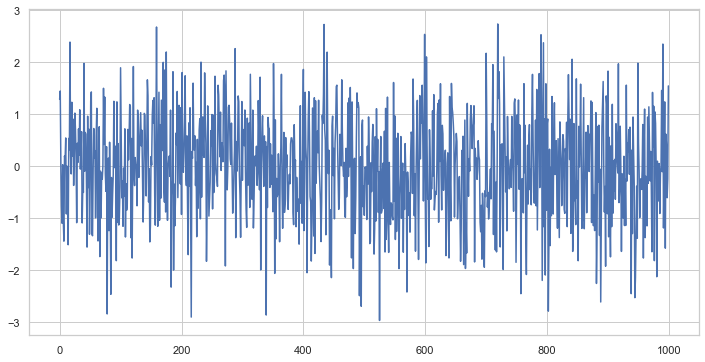

In [18]:
series.plot(figsize=(12,6))
plt.show()

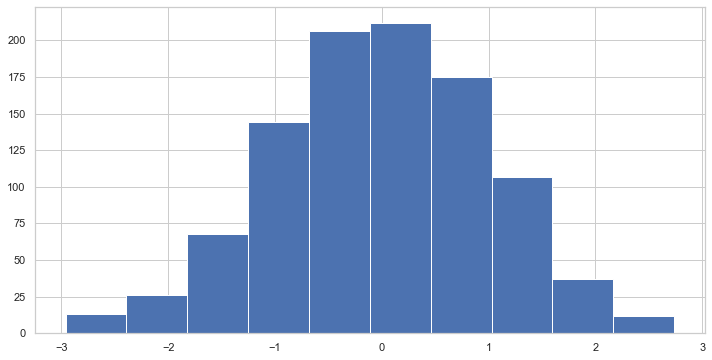

In [19]:
# histogram plot
series.hist(figsize=(12,6))
plt.show()

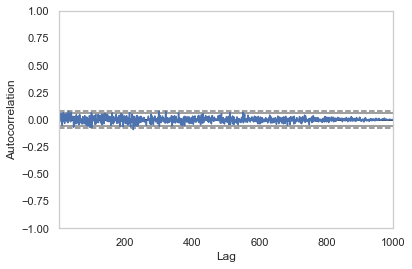

In [20]:
# autocorrelation
autocorrelation_plot(series)
plt.show()

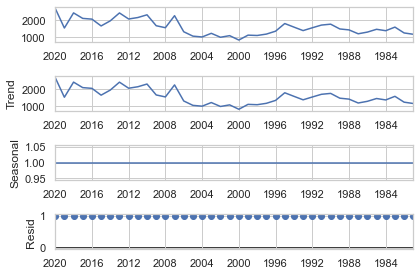

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

train.set_index('year',inplace=True)

analysis = train[['value']].copy()
x=analysis

decompose_result_mult = seasonal_decompose(x, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [130]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
plt.rcParams.update({'figure.figsize' : (9,7), 'figure.dpi' : 120})  

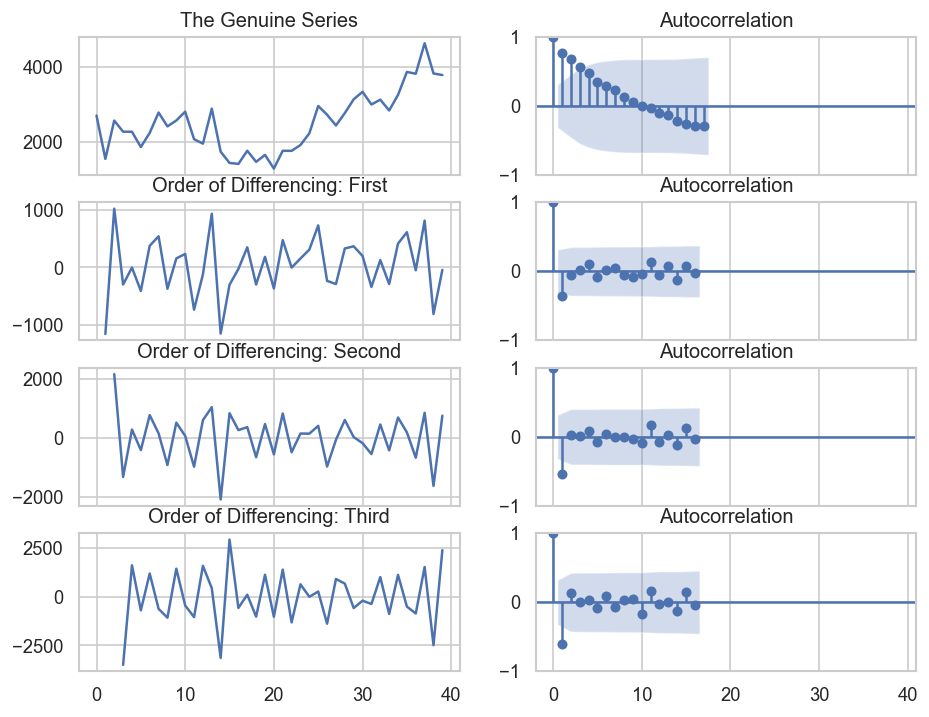

In [131]:
fig, axes = plt.subplots(4, 2, sharex = True)  

# The Genuine Series  
axes[0, 0].plot(train.value); axes[0, 0].set_title('The Genuine Series')  
plot_acf(train.value, ax = axes[0, 1])  

# Order of Differencing: First  
axes[1, 0].plot(train.value.diff()); axes[1, 0].set_title('Order of Differencing: First')  
plot_acf(train.value.diff().dropna(), ax = axes[1, 1])  

# Order of Differencing: Second  
axes[2, 0].plot(train.value.diff().diff()); axes[2, 0].set_title('Order of Differencing: Second')  
plot_acf(train.value.diff().diff().dropna(), ax = axes[2, 1])  

# Order of Differencing: Third  
axes[3, 0].plot(train.value.diff().diff().diff()); axes[3, 0].set_title('Order of Differencing: Third')  
plot_acf(train.value.diff().diff().diff().dropna(), ax = axes[3, 1])  

plt.show()

In [89]:
train['FirstDiff'] = train['value'].diff(periods=1)

In [90]:
train

,year,value,FirstDiff
0,2021-01-01,2704.680083,NaN
1,2020-01-01,1548.614422,-1156.065661
2,2019-01-01,2570.691303,1022.076881
3,2018-01-01,2274.389070,-296.302233
4,2017-01-01,2272.228328,-2.160742
...,...,...,...
35,1986-01-01,3869.702256,613.363487
36,1985-01-01,3821.396554,-48.305702
37,1984-01-01,4635.904927,814.508373
38,1983-01-01,3828.425452,-807.479475


In [91]:
#Auto Correction
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(train['FirstDiff'])

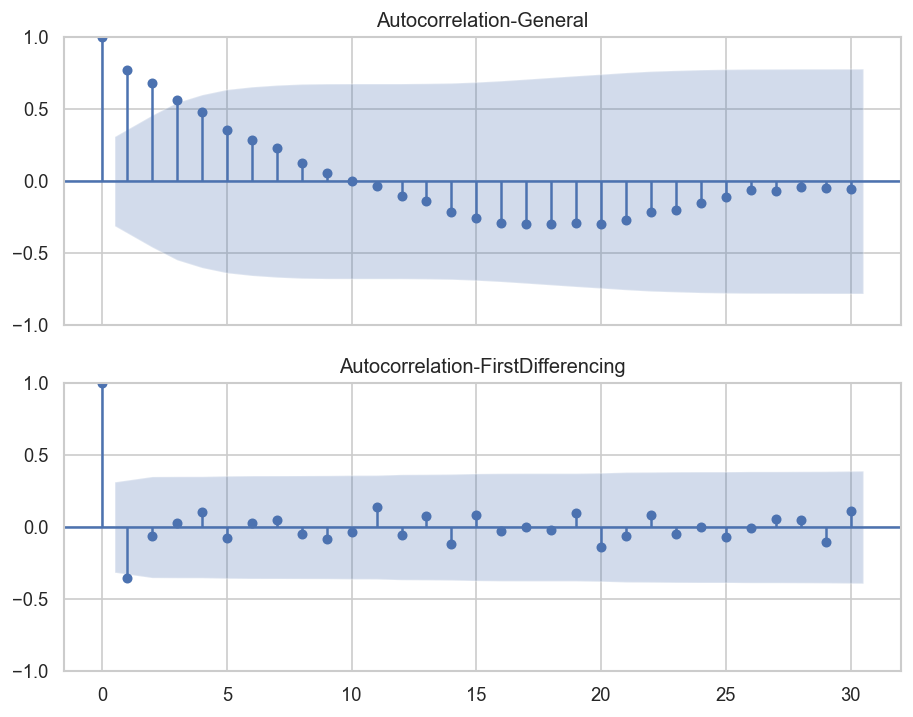

In [92]:
fig, axes = plt.subplots(2, sharex = True)  

# Plot autocorrelation for general
plot_acf(train['value'], ax =axes[0],title='Autocorrelation-General' ,lags=30);

# Plot autocorrelation for first differencing
plot_acf(train.FirstDiff.dropna(),title='Autocorrelation-FirstDifferencing', ax =axes[1] ,lags=30);

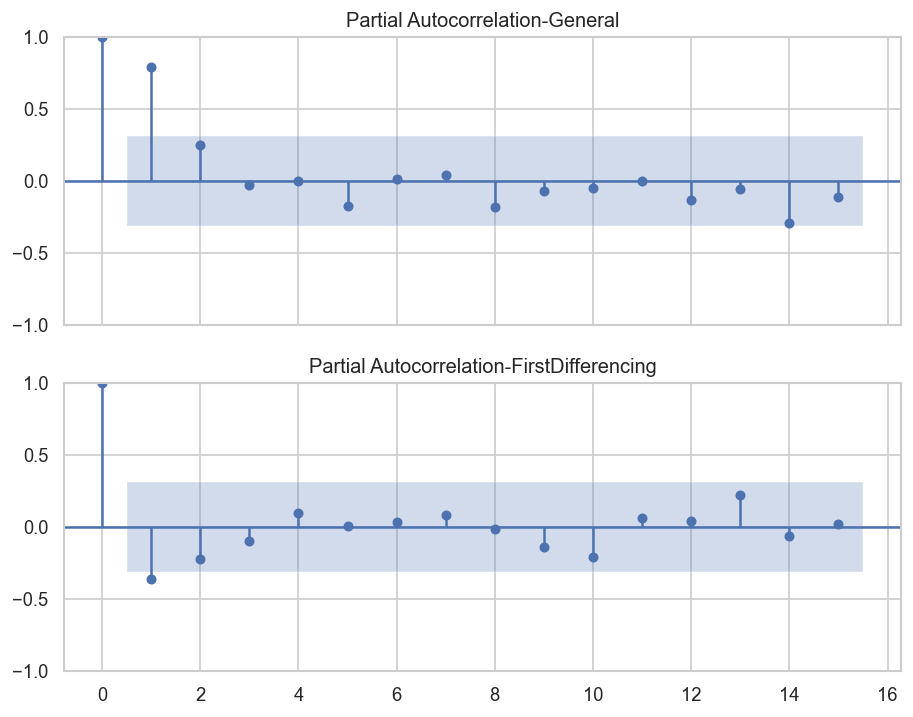

In [93]:
fig, axes = plt.subplots(2, sharex = True)  

# Plot autocorrelation for general
plot_pacf(train['value'], ax =axes[0],title='Partial Autocorrelation-General' ,lags=15);

# Plot autocorrelation for first differencing
plot_pacf(train.FirstDiff.dropna(),title='Partial Autocorrelation-FirstDifferencing', ax =axes[1] ,lags=15);

In [94]:
from statsmodels.tsa.arima.model import ARIMA

In [95]:
# 2,0,0 ARIMA Model
model = ARIMA(train.value,order=(2,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   40
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -302.323
Date:                Fri, 19 Aug 2022   AIC                            612.646
Time:                        11:28:56   BIC                            619.401
Sample:                             0   HQIC                           615.088
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2700.5767    528.018      5.115      0.000    1665.680    3735.474
ar.L1          0.5555      0.140      3.961      0.000       0.281       0.830
ar.L2          0.3115      0.155      2.004      0.0

In [96]:
# 1,1,1 ARIMA Model
model_dif = ARIMA(train.value,order=(1,1,1))
model_dif_fit = model_dif.fit()
print(model_dif_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   40
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -293.833
Date:                Fri, 19 Aug 2022   AIC                            593.667
Time:                        11:28:57   BIC                            598.657
Sample:                             0   HQIC                           595.457
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1610      0.335     -0.480      0.631      -0.818       0.496
ma.L1         -0.3214      0.345     -0.932      0.351      -0.997       0.355
sigma2      2.095e+05   5.58e+04      3.756      0.0

<AxesSubplot:xlabel='year'>

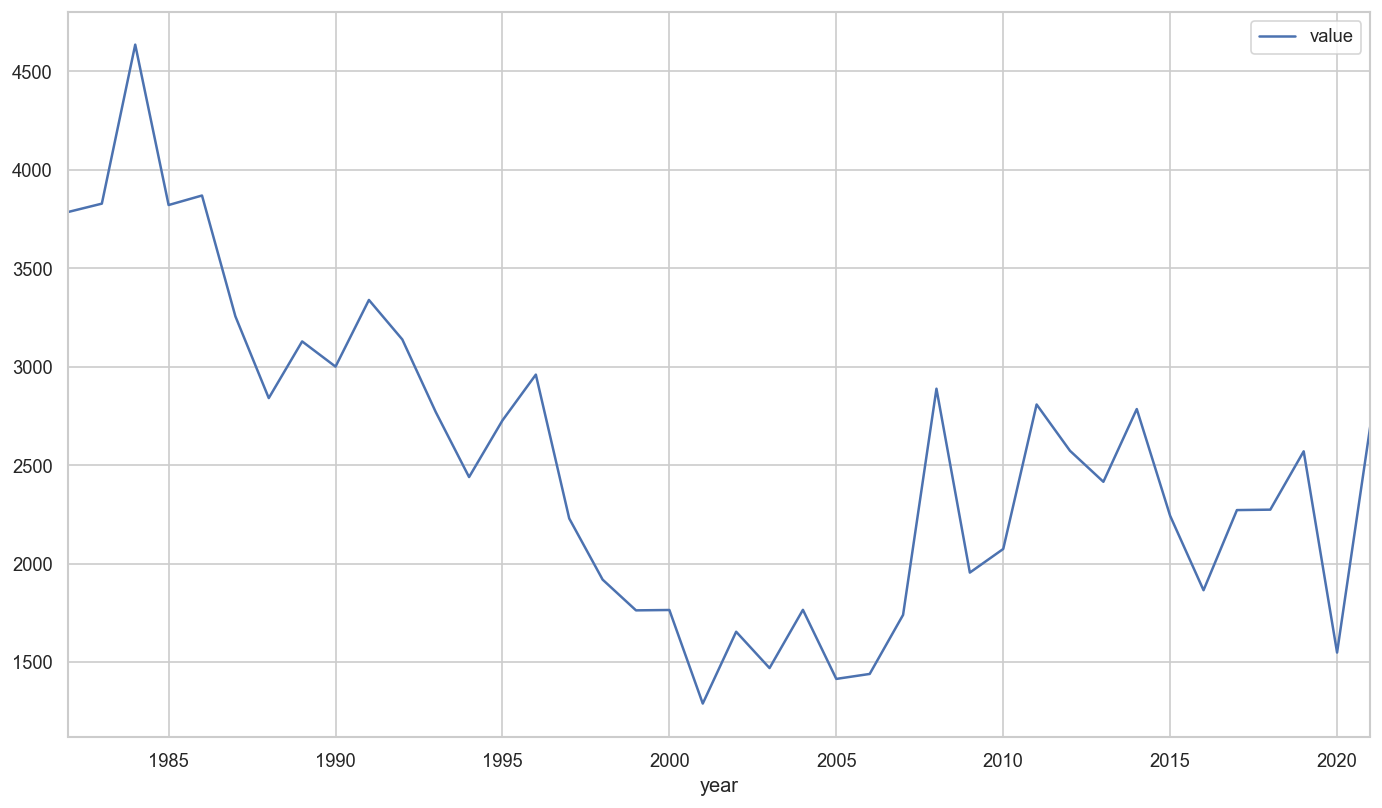